In [1]:
from gbmi.exp_max_of_n.train import MAX_OF_10_CONFIG
from gbmi.model import train_or_load_model
import torch
from torch import tensor

In [45]:
%load_ext autoreload
%autoreload 2

In [2]:
config = MAX_OF_10_CONFIG

In [46]:
config

Config(experiment=MaxOfN(n_train_samples=None, n_test_samples=1024, force_adjacent=False, training_ratio=0.7), n_layers=1, n_heads=1, d_model=32, d_head=32, d_mlp=None, d_vocab=64, n_ctx=10, zero_biases=True, deterministic=True, seed=123, batch_size=128, train_for=(15000, 'steps'), log_every_n_steps=10)

In [4]:
rundata, model = train_or_load_model(config)

wandb:   1 of 1 files downloaded.  


In [5]:
model

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0): TransformerBlock(
      (ln1): Identity()
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (hook_resid_pre): HookPoint()
      (hook_resid_post): HookPoint()
    )
  )
  (unembed): Unembed()
)

In [15]:
rundata.test_metrics

[{'test_loss': 0.01093942578881979, 'test_acc': 0.9970703125}]

# Empirical tests

In [7]:
dm = config.experiment.get_datamodule()(config)

In [8]:
dm.setup("fit")

> Try a sample from the dataloader.

In [9]:
t = next(iter(dm.train_dataloader()))

In [24]:
model(t).argmax(dim=-1)

tensor([[32, 32, 32,  ..., 53, 53, 53],
        [43, 43, 27,  ..., 27, 56, 56],
        [61, 61, 61,  ..., 61, 61, 61],
        ...,
        [44, 44, 44,  ..., 44, 46, 50],
        [62, 62, 62,  ..., 62, 62, 62],
        [43, 43, 44,  ..., 63, 63, 63]])

In [31]:
(t.max(dim=-1).values == model(t).argmax(dim=-1)[:,-1]).float().mean()

tensor(1.)

Seems to work.

> What if we give 'all the same token' as input?

In [88]:
for i in range(config.d_vocab):
    result = model(tensor([[i] * 10])).argmax(dim=-1)[0,0].item()
    print(i, result, i == result)

0 27 False
1 43 False
2 43 False
3 32 False
4 32 False
5 32 False
6 32 False
7 43 False
8 43 False
9 32 False
10 43 False
11 32 False
12 43 False
13 32 False
14 32 False
15 43 False
16 32 False
17 43 False
18 32 False
19 32 False
20 32 False
21 27 False
22 32 False
23 43 False
24 32 False
25 25 True
26 32 False
27 27 True
28 28 True
29 29 True
30 30 True
31 31 True
32 32 True
33 33 True
34 34 True
35 35 True
36 36 True
37 37 True
38 38 True
39 39 True
40 40 True
41 41 True
42 42 True
43 55 False
44 44 True
45 45 True
46 46 True
47 47 True
48 48 True
49 49 True
50 50 True
51 51 True
52 52 True
53 53 True
54 54 True
55 55 True
56 56 True
57 57 True
58 58 True
59 59 True
60 60 True
61 61 True
62 62 True
63 63 True


We fail on sequences `[i,...,i]` for `i in ([0..24] + [26, 43])`

# Analysis

In [89]:
import gbmi.analysis_tools.l1h1 as l1h1
import gbmi.analysis_tools.plot as plot

In [90]:
W_U, W_E, W_pos, W_V, W_O = model.W_U, model.W_E, model.W_pos, model.W_V, model.W_O

## OV matrix

> How does OV of each token affect the output logits?

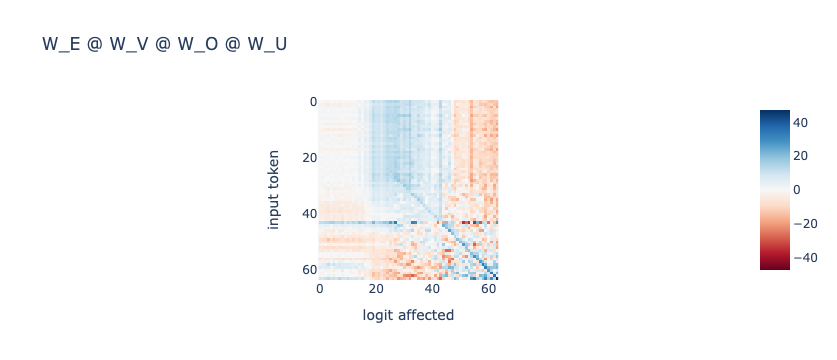

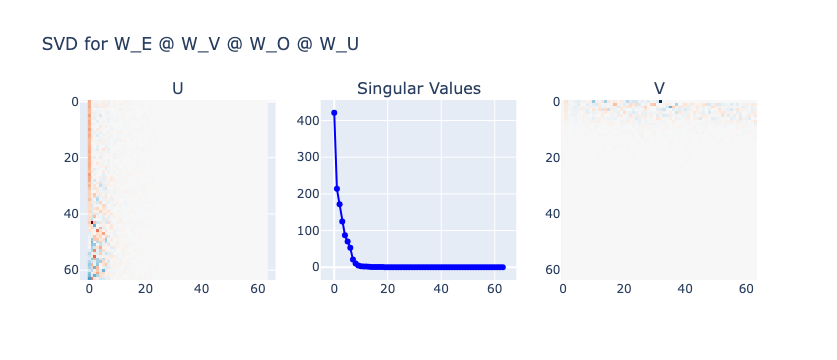

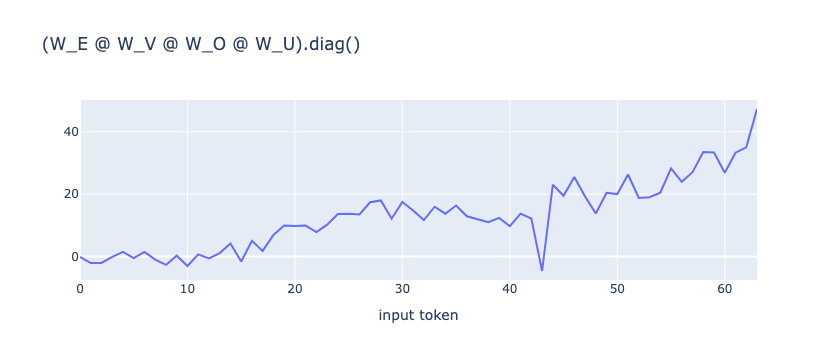

In [92]:
l1h1.analyze_EVOU(model)

> What does positional encoding do?

Seems to add some marginal logit diff (probably not important?) to the output logits... which is negative before ~35 and positive afterwards. Notably it drops at 64.

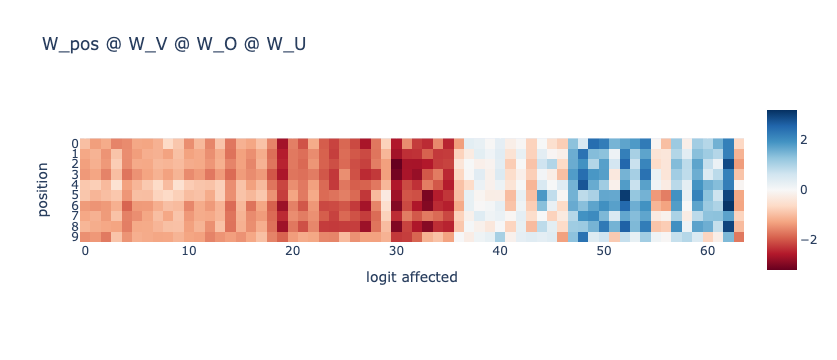

In [93]:
l1h1.analyze_PVOU(model)

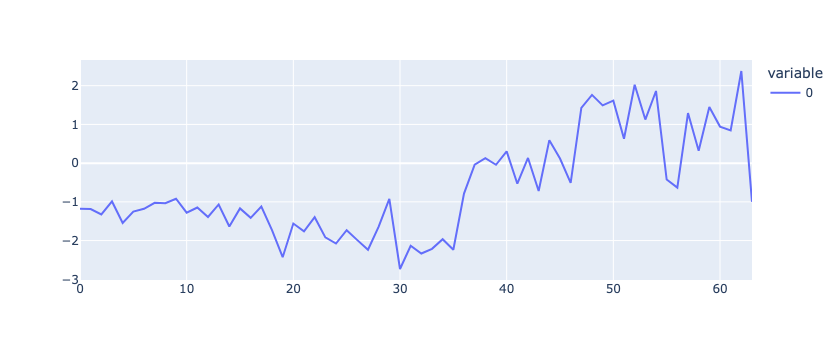

In [94]:
plot.line((W_pos @ W_V @ W_O @ W_U).squeeze().mean(dim=0))

## QK matrix

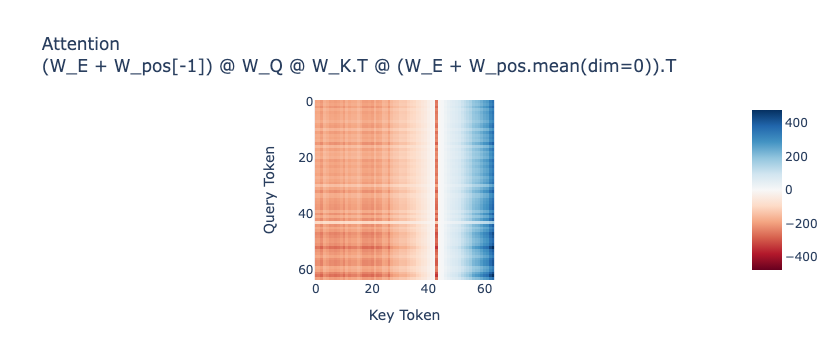

In [95]:
l1h1.analyze_QK(model)

QK is roughly monotonically increasing